In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io

In [3]:
data_dir = '../../../data/'

In [4]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

In [5]:
expdesign = scipy.io.loadmat(data_dir+'nsddata/experiments/nsd/nsd_expdesign.mat')
sharedix = expdesign['sharedix']

all_ids = []
shared_mask = []
shared_id_nums = []
max_session = np.zeros(len(subjid))
for sidx, sid in enumerate(subjid):
    
    data = pd.read_csv('../../../data/nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')
    
    max_session[sidx] = np.max(np.array(data['SESSION'])) 
    
    all_ids.append(np.array(data['73KID']))
    
    shared_mask.append(np.isin(all_ids[sidx],sharedix))
    shared_id_nums.append(np.array(data['73KID'])[shared_mask[sidx]])

In [6]:
shared_3_reps = []
for sidx, sid in enumerate(subjid):
    vals, idx_start, count = np.unique(shared_id_nums[sidx], return_counts=True,
                                    return_index=True)
    shared_3_reps.append(vals[count == 3])
    
least_trials = min(shared_3_reps, key=len)


In [7]:
#okay let's find the shared id numbers again, but this time for the set of images 
#that was actually shown 3 times to each subject

shared_id_nums_3reps = []
shared_mask_3reps = []
for sidx, sid in enumerate(subjid):
    
    data = pd.read_csv('../../../data/nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')
    
    shared_mask_3reps.append(np.isin(all_ids[sidx],least_trials))
    
    shared_id_nums_3reps.append(np.array(data['73KID'])[shared_mask_3reps[sidx]])
    
#these id numbers are actually the same for each subject 
#(subjs were purposefully shown shared images at same trial nums)
#but b/c lengths are diff just kept it like this for ease

In [8]:
shared_betas_3reps = []
for sidx, sid in enumerate(subjid):
    
    print(sid)
    mask = shared_mask_3reps[sidx]
    
    for sess in range(1,int(max_session[sidx])+1):
        
        if(sess < 10):
            idx = '0' + str(sess)
        else:
            idx = str(sess)

        raw_betas = h5py.File(data_dir+'nsddata_betas/ppdata/subj'+ sid +'/nativesurface/betas_fithrf_GLMdenoise_RR/rh.betas_session'+idx+'.hdf5', 'r')
        betas = raw_betas['betas'][:]/300
        
        sess_shared_betas = betas[mask[(sess-1)*750:sess*750]]

        if(sess==1):
            subj_shared_betas = sess_shared_betas
        else:
            subj_shared_betas = np.concatenate((subj_shared_betas, sess_shared_betas))
    
    shared_betas_3reps.append(subj_shared_betas)

01
02
03
04
05
06
07
08


In [9]:
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [10]:
sorted_shared_betas = []
for sidx, sid in enumerate(subjid):
    arr1inds = shared_id_nums_3reps[sidx].argsort()
    sorted_shared_betas.append(shared_betas_3reps[sidx][arr1inds[::-1]])

In [11]:
del shared_betas_3reps #to help with memory probs

In [12]:
sorted_shared_betas[0][0::3].shape

(515, 226601)

In [13]:
betas_by_repeat = [[] for _ in range(len(subjid))]
for sidx, sid in enumerate(subjid):
    for r in range(3):
        betas_by_repeat[sidx].insert(r,sorted_shared_betas[sidx][r::3])

In [14]:
betas_by_repeat[0][0].shape #subj 01, first stim presentation - images x voxels

(515, 226601)

In [15]:
betas_by_repeat[0][0][:,1:10].shape

(515, 9)

In [16]:
#3 possible combos (trial 1 vs mean 2 & 3; trial 2 vs mean 1 & 3; trial 3 vs mean 1 & 2)

repeat_mean = [[] for _ in range(len(subjid))]

for sidx, sid in enumerate(subjid):
    
    repeat_mean[sidx].insert(0,np.mean([betas_by_repeat[sidx][1],betas_by_repeat[sidx][2]],
                                       axis=0)) #mean 2 & 3
    repeat_mean[sidx].insert(1,np.mean([betas_by_repeat[sidx][0],betas_by_repeat[sidx][2]],
                                       axis=0)) #mean 1 & 3
    repeat_mean[sidx].insert(2,np.mean([betas_by_repeat[sidx][0],betas_by_repeat[sidx][1]],
                                       axis=0)) #mean 1 & 2

In [17]:
# let's organize by ROI and get rid of vox outside of our ROIs to save space
betas_by_repeat_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
repeat_mean_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]

#two loops because otherwise we run out of mems
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        for r in range(3):       
            betas_by_repeat_by_ROI[sidx][roi_idx].insert(r,betas_by_repeat[sidx][r][:,rh_streams[sidx] == roi_idx+1])

del betas_by_repeat

for sidx, sid in enumerate(subjid):    
    for roi_idx in range(len(ROI_names)-1):           
        for r in range(3):           
            repeat_mean_by_ROI[sidx][roi_idx].insert(r,repeat_mean[sidx][r][:,rh_streams[sidx] == roi_idx+1])

del repeat_mean

In [19]:
betas_by_repeat_by_ROI[0][0][2].shape

(515, 13399)

## RSMS

In [20]:
#TO DO: PUT THIS IN UTILS

# credit to https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

### THIS IS ACTUALLY EQUIVALENT TO (TESTED) 
#full = np.corrcoef(x,y)
#full[:1000,1000:]

In [23]:
#Create RSMS

flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, (betas_by_repeat_by_ROI[0][0][0].shape[0])**2,3))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):

        for r in range(3):

            rsm = corr2_coeff(betas_by_repeat_by_ROI[sidx][roi_idx][r], repeat_mean_by_ROI[sidx][roi_idx][r])

            lower = np.tril(rsm, -1).T.ravel()
            diag = np.diag(rsm)
            upper = np.triu(rsm, 1).T.ravel()

            flat_rsm[sidx, roi_idx, :,r] = np.concatenate([lower[lower != 0], diag, upper[upper != 0]])


In [24]:
flat_rsm.shape #subj x ROI x flattened rsm vals x combo

(8, 7, 265225, 3)

In [26]:
rsm_corr_within_subj_within_ROI = np.zeros((len(subjid),len(ROI_names)-1,3))

#within subj & ROI
for sidx, sid in enumerate(subjid):
    for roi_idx in range(len(ROI_names)-1):

        rsm_corr = [stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,1])[0],
                    stats.pearsonr(flat_rsm[sidx,roi_idx,:,0],flat_rsm[sidx,roi_idx,:,2])[0],
                    stats.pearsonr(flat_rsm[sidx,roi_idx,:,1],flat_rsm[sidx,roi_idx,:,2])[0]]

        rsm_corr_within_subj_within_ROI[sidx,roi_idx,:] = rsm_corr

In [32]:
mean_rsm_corr_within_subj_within_ROI = np.mean(rsm_corr_within_subj_within_ROI,axis=2) #mean across repeats

In [33]:
mean_rsm_corr_within_subj_within_ROI.shape

(8, 7)

In [35]:
len(np.mean(mean_rsm_corr_within_subj_within_ROI, axis=0))

7

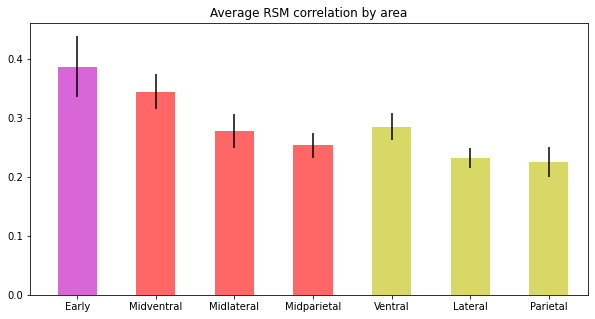

In [53]:
data = mean_rsm_corr_within_subj_within_ROI
error = stats.sem(mean_rsm_corr_within_subj_within_ROI, axis=0)

plt.figure(figsize=(10, 5))
xlocations = np.array(range(data.shape[1]))+.1
width = 0.5
plt.bar(xlocations, np.mean(mean_rsm_corr_within_subj_within_ROI, axis=0), 
        yerr=error, width=width, color = ['m','r','r','r','y','y','y'], alpha = .6)
plt.xticks(xlocations, ROI_names[1:])
plt.xlim(-0.5, xlocations[-1]+width)
plt.title("Average RSM correlation by area")
plt.gca().get_yaxis().tick_left()
plt.gca().get_xaxis().tick_bottom()
plt.show()

In [ ]:
#within
for sidx, sid in enumerate(subjid):
    print(sid)
    print(stats.pearsonr(flat_rsm_VENTRAL[sidx,:,0],flat_rsm_VENTRAL[sidx,:,1])[0])
    print(stats.pearsonr(flat_rsm_VENTRAL[sidx,:,0],flat_rsm_VENTRAL[sidx,:,2])[0])
    print(stats.pearsonr(flat_rsm_VENTRAL[sidx,:,1],flat_rsm_VENTRAL[sidx,:,2])[0])

In [ ]:
#within
for sidx, sid in enumerate(subjid):
    print(sid)
    print(stats.pearsonr(flat_rsm_LATERAL[sidx,:,0],flat_rsm_LATERAL[sidx,:,1])[0])
    print(stats.pearsonr(flat_rsm_LATERAL[sidx,:,0],flat_rsm_LATERAL[sidx,:,2])[0])
    print(stats.pearsonr(flat_rsm_LATERAL[sidx,:,1],flat_rsm_LATERAL[sidx,:,2])[0])

In [ ]:
for sidx, sid in enumerate(subjid):
    print(sid)
    alt_combos = [stats.pearsonr(flat_rsm_LATERAL[sidx,:,0],flat_rsm_VENTRAL[sidx,:,1])[0],
              stats.pearsonr(flat_rsm_LATERAL[sidx,:,0],flat_rsm_VENTRAL[sidx,:,2])[0],
              stats.pearsonr(flat_rsm_LATERAL[sidx,:,1],flat_rsm_VENTRAL[sidx,:,0])[0],
              stats.pearsonr(flat_rsm_LATERAL[sidx,:,1],flat_rsm_VENTRAL[sidx,:,2])[0],
              stats.pearsonr(flat_rsm_LATERAL[sidx,:,2],flat_rsm_VENTRAL[sidx,:,0])[0],
              stats.pearsonr(flat_rsm_LATERAL[sidx,:,2],flat_rsm_VENTRAL[sidx,:,1])[0]]
    
    same_pres = [stats.pearsonr(flat_rsm_LATERAL[sidx,:,0],flat_rsm_VENTRAL[sidx,:,0])[0],
                stats.pearsonr(flat_rsm_LATERAL[sidx,:,1],flat_rsm_VENTRAL[sidx,:,1])[0],
                stats.pearsonr(flat_rsm_LATERAL[sidx,:,2],flat_rsm_VENTRAL[sidx,:,2])[0]]
    
    print(np.mean(alt_combos))
    print(np.mean(same_pres))